In [1]:
#Installing keras of this version that supports visualization activations
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-9tuudnmm
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-9tuudnmm
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38886 sha256=a94288947044babb3e5b772e563fcee4f933d8ed2deb3321bb40a2ef6e163e76
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0hdoq62/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [1]:
#Importing required libraries for dataframe, linear algebra, plotting,data pre-processing, CNN model, etc.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from keras.metrics import categorical_accuracy
from keras.optimizers import *

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
#Creates the Choose Files tab which allows the user to upload the file, in current case the file uploaded is train.csv
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
#Read training and test data files
#Reads the train.csv file uploaded by the user and converts it to dataframe
import io
dftrain =  pd.read_csv(io.BytesIO(uploaded['train.csv']))


In [54]:
#Similarly upload the test data file and convert it to dataframe
uploaded = files.upload()
dftest =  pd.read_csv(io.BytesIO(uploaded['test.csv']))   


Saving test.csv to test.csv


In [4]:
#Display first few rows of training data
dftrain.head()

#As per data description images are of 48x48 pixels
#Training dataframe:
#Each row represents a single image having two attributes/columns - 'feature','label'
#'feature' column consists of 48*48=2034 pixel values for that particular image.
#'label' column indicates the type of emotion depicted by the image.

,label,feature
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
#Checking the number of distinct target classes/emotion types using set()
print(set(dftrain['label']))

{0, 1, 2, 3, 4, 5, 6}


In [6]:

# Images are of 48x48 pixels. Hence, IMG_ROWS and IMG_COLS are assigned value of 48, which will be used in later stages of model building
IMG_ROWS = 48
IMG_COLS = 48
#There are 7 distinct emotions in the dataset (target labels)
NUM_CLASSES = set(dftrain['label'])

#Creating a dictionary which maps the 7 classes to corresponding category of Sentiments
image_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy',
  4:'Sad', 5:'Surprise', 6:'Neutral'}

#Check the total number of images belonging to each category of emotions/target labels.
emotions = dftrain['label'].value_counts(sort=False).reset_index()
emotions.columns = ['label', 'count']
emotions['label'] = emotions['label'].map(image_dict)
emotions

,label,count
0,Angry,2803
1,Disgust,324
2,Fear,2915
3,Happy,5008
4,Sad,3357
5,Surprise,2132
6,Neutral,3460


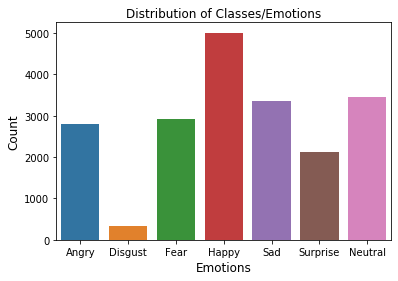

In [7]:
# Plotting a bar graph for class distributions
import seaborn as sns
plt.figure(figsize=(6,4))
sns.barplot(emotions['label'], emotions['count'])
plt.title('Distribution of Classes/Emotions')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#There are very few images representing Disgust class and more images represent Happy class.

In [8]:
#Splitting 2034 individual pixel values from feature column of dataframe-dftrain into 2034 columns and assigned to new dataframe "X", where each pixel value is stored in different column, at its respective position columns
X = dftrain['feature'].str.split(expand=True)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,95,79,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,131,104,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,139,135,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,187,188,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,48,38,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30


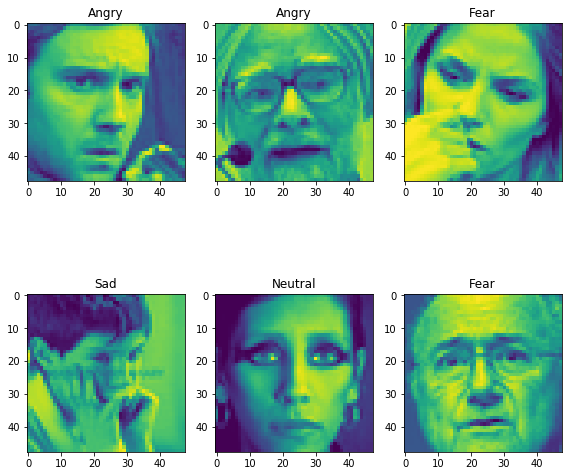

In [9]:
#Displaying few images from the training dataset

#Serializing first 6 rows of dataframe X which has pixel values
X_train = np.array(X.iloc[:6,0:])

#Serializing first 6 rows of label column from dataframe
Y_train = np.array(dftrain.iloc[:6,0])

#Convert int value to float
X_train = X_train.astype('float32')

#Displaying the images with their corresponding labels
plt.figure(figsize=(8,12))
for i in range(0, 6):
    plt.subplot(3,3, i+1)
    plt.imshow(X_train[i].reshape(IMG_ROWS,IMG_COLS))
    plt.title(image_dict[Y_train[i]])
    plt.tight_layout()
    


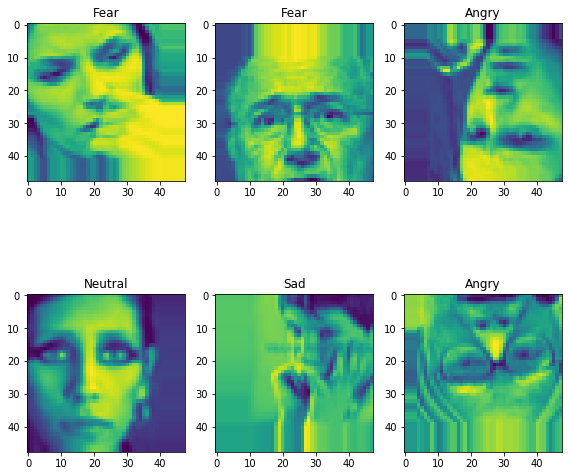

In [10]:
#Applying the preprocessing on 6 images using ImageDataGenerator

#Reshape to X_train from 2-D array to be [samples][width][height][color_channel]
X_train = X_train.reshape(X_train.shape[0], 48, 48,1)

# convert from int to float
X_train = X_train.astype('float32')

# Define data preparation for Augmentation process for data transformation

#Random Shift operation is performed for augmentation step. The purpose is that some objects may not be centered in the image frame. 
#So to handle off-centered images, we can use the shift parameters which shifts all the pixel values of images in one direction (horizontally/vertically) keeping the dimensions same
# shift=0.2 causes the image to shift by 20%
shift = 0.2
#Create a variable of ImageDataGenerator and pass the augmentation parameters required
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift,horizontal_flip=True, vertical_flip=True)

# fit parameters from data
datagen.fit(X_train)

plt.figure(figsize=(8,12))

# configure batch size and retrieve one batch of images, flow returns the images as per batch size
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=6):
    # create a grid of 2x3 images and print the transformed images with the label
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48))
        plt.title(image_dict[y_batch[i]])
        plt.tight_layout()
    break

In [11]:
#Define the X(features) and Y(target) in the dataset. 
#Since Y has labels as class numbers, it is converted to one-hot label using to_categorical() fucntion.

from tensorflow.python.keras.utils import to_categorical

X = np.array(X.iloc[:,0:])

Y = to_categorical(np.array(dftrain.iloc[:,0]))

#Split the dataset into training and validation sets.
#Here we split data into 80:20 ratio for training and validation to optimiza classifier during training
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=13)

#Checking the shape of X_train and Y_train
print("Shapes: ",X_train.shape,Y_train.shape)

#Reshape the data from 2034 to [samples][48][48][color channel]
X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, 1)
X_val = X_val.reshape(X_val.shape[0], IMG_ROWS, IMG_COLS, 1)

#Checking the shape of X_train and Y_train after reshaping
print("After Reshaping: ",X_train.shape,Y_train.shape)

#Convert int values to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

#Normalize the data
X_train /= 255.0
X_val /= 255.0



Shapes:  (15999, 2304) (15999, 7)
After Reshaping:  (15999, 48, 48, 1) (15999, 7)


In [12]:
#Building the CNN model.

#Architecture details:

#Creating a sequential model so that all layers are stacked sequentially by keras.

#There are 4 main Convolution layers. Each main Convolution layer has 2 Convolution layer followed by BatchNormalization, MaxPooling and Dropout layers respectively.
#Conv2D-Conv2D-BatchNorm-MaxPooling-Dropout

#Convolution layers has increasing number of kernels 64,128,256,512 in every main convolution layer respectively. 
#The two convolution layers within a main convolution has same number of kernels such as main layer 1 has 64, 64 kernels in Conv2D.

#The size of kernel/filter is 3x3 and every convolution layer uses the same kernel size. Same padding type is used.
#For first layer, the input shape is specified same as the input shape of image (48,48,1), kernel_initializer of 'he_normal' is used for setting initial weights.
#BatchNormalization is added after every convolution and FC layers to standardize the layer inputs ans accelerate the training process
#There are 4 pooling layers and all are MaxPooling. The kernel size for pooling layer is 2x2.
#A dropout of 0.2 is applied after first 3 layers and a dropout of 0.4 is is applied after last Convolution layer to prevent overfitting.

#The output from last convolution layer is flattened using Flatten() which generates 128 outputs. 
#Flattened outputs from previous layer are fed as input to first Fully Connected layer of size 128.

#There are 2 Fully Connected layer with increasing kernels 128, 512, each of the dense layers are followed by BatchNormalization, Activation and Dropout layers. Dropout of 0.3 is used for Fully Connected layers. The 2nd Fully Connected layer is finally connected to the last layer with size 7 (i.e. the number of output classes to classify into). 
#The activation function for all the layers is ReLu and for the last layer, it is softmax.

#Overall Design layout :

#Conv2D-Conv2D-BatchNorm-MaxPooling-Dropout
#Conv2D-Conv2D-BatchNorm-MaxPooling-Dropout
#Conv2D-Conv2D-BatchNorm-MaxPooling-Dropout
#Conv2D-Conv2D-BatchNorm-MaxPooling-Dropout
#Flatten
#FC-BatchNorm-Activation-Dropout
#FC-BatchNorm-Activation-Dropout
#Output layer

#The model consists of 5,314,375 parameters out of which 5,311,687 are trainable and 2,688 Non-trainable params.

#After the architecture is built the model is compiled
#The loss function used is categorical_crossentropy because our targets is in categorical format.
#this loss function works best for multi-class classification with categorical output/target.

#The optimizer used is Adam as it combines the advantages of other extensions of stochastic gradient descent i.e Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp)

#input shape = 48,48,1
input_shape = (IMG_ROWS, IMG_COLS, 1)


#Initializing CNN
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=input_shape, kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolutional Layer
model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolutional Layer
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4th Convolutional Layer
model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#Flattening
model.add(Flatten())

#Fully Connected Layer - 1st layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Fully Connected Layer - 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Last layer with 7 output since there are 7 target classes. Naming this layer so that it could be used for plotting saliency map later.
model.add(Dense(7,name='visualized_layer'))
model.add(Activation('softmax'))
    
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

#print the summary of model
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [13]:
#Training and validating the model 
#The batch size denotes the size of batch of images generated after augmentation. The ImageDataGenerator is fitted on training data.
#The number of epochs selected for training and validation is 100 and the trained model is validated against validation set.

#Save the model
model.save("myCNNmodel.h5")

#fit
nb_epoch = 100
batch_size = 32
datagen.fit(X_train)

#Explicitly setting the learning rate
K.set_value(model.optimizer.lr,1e-3) 

#When fit_generator is used, keras calls Augmentation generator function-datagen() first, 
#which provides a specified batch size data to fit_generator() so that it can perform back-propagation on it and update weights to train model.

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), steps_per_epoch=X_train.shape[0]//batch_size, epochs=nb_epoch, validation_data=(X_val, Y_val), shuffle=True, verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
499/499 [==============================] - 35s 70ms/step - loss: 1.9615 - acc: 0.2164 - val_loss: 1.8782 - val_acc: 0.2313
Epoch 2/100
499/499 [==============================] - 26s 52ms/step - loss: 1.8524 - acc: 0.2303 - val_loss: 1.8565 - val_acc: 0.1958
Epoch 3/100
499/499 [==============================] - 26s 53ms/step - loss: 1.8266 - acc: 0.2381 - val_loss: 1.7762 - val_acc: 0.2467
Epoch 4/100
499/499 [==============================] - 26s 52ms/step - loss: 1.8082 - acc: 0.2455 - val_loss: 1.7756 - val_acc: 0.2537
Epoch 5/100
499/499 [==============================] - 26s 52ms/step - loss: 1.7938 - acc: 0.2554 - val_loss: 1.7944 - val_acc: 0.2597
Epoch 6/100
499/499 [==============================] - 26s 53ms/step - loss: 1.7550 - acc: 0.2789 - val_loss: 1.7244 - val_acc: 0.2925
Epoch 7/100
499/499 [==============================] - 26s 52ms/step - loss: 1.6795 - acc: 0.3

In [0]:
#Model Performance:
#From the training and validation we can see after last epoch the training accuracy was 0.7452 and validation accuracy being 0.6458. 
#Similarly training loss was at 0.6944 and validation loss at 1.0586

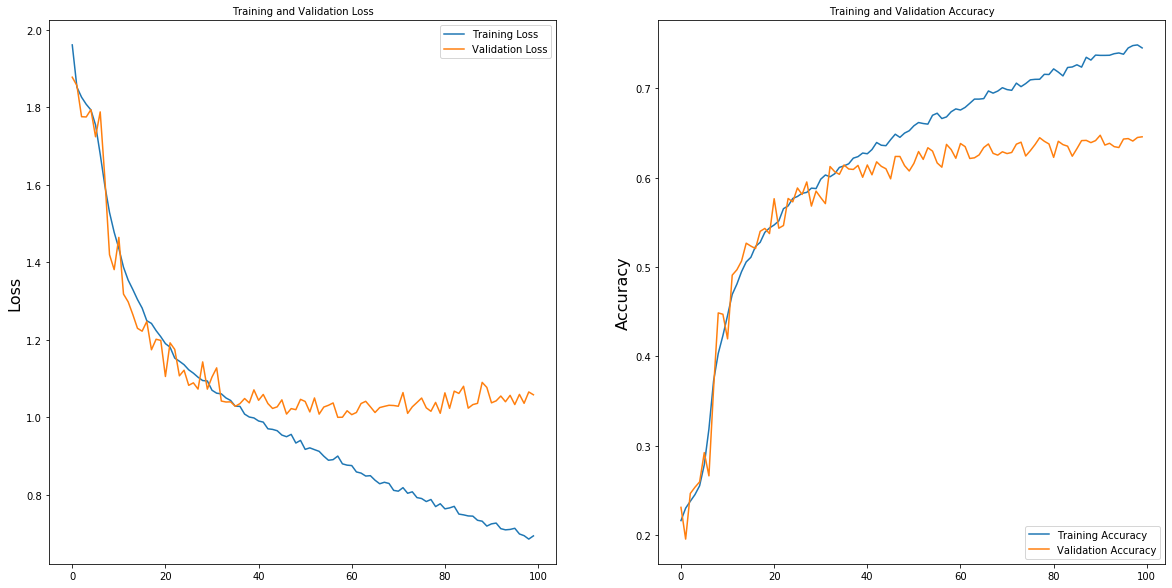

In [59]:
# Plotting the training and validation accuracies & loss in each epoch.
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Loss', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Accuracy', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [0]:
#From the accuracy graph we can see both training and validation accuracy increases as the number of epochs increases which tells the model is learning and becoming better after every epoch
#Similarly from the loss graph we can see both training and validation loss decreases with the number of epochs.
#Since in both the graphs the lines are closely following each other or converging to a certain extent signifies that there is no overfitting of data.

In [60]:
#Displaying few rows of test dataframe
dftest.head()

#dftest dataframe has ID column to denote the ID of image and feature column with 2034 pixel values for every row
#No label is provided

,id,feature
0,0,89 119 131 137 145 150 158 164 168 172 176 182...
1,1,56 84 137 114 78 158 114 139 132 143 121 155 1...
2,2,10 30 86 78 65 56 71 68 67 93 124 122 79 54 86...
3,3,255 255 255 253 255 202 157 111 47 40 30 32 30...
4,4,82 75 31 33 40 34 56 59 55 64 56 40 44 48 47 5...


In [0]:
#feature column from test dataframe is split into 2034 pixel values and stored in 2034 columns of new dataframe- Xtst
Xtst = dftest['feature'].str.split(expand=True)

#Serializing the pixel values of test images
Xtest = np.array(Xtst.iloc[:,0:])


#Reshape the data from 2-D array to [samples][width][height][color_channel]
X_test = Xtest.reshape(Xtest.shape[0], IMG_ROWS, IMG_COLS, 1)


#Convert int values to float
X_test = X_test.astype('float32')

#Normalize the test data before feeding it to the model, just the same way as training data
X_test /= 255.0




In [0]:
#The test data - X_test is fed to the model to get predictions/target results which is stored in 'y_pred'
y_pred=model.predict(X_test)

In [63]:
#Model generates the probability values for all class labels for each test image. So each image has 7 output values
print("y_pred results:",y_pred,"\n")

#We need to determine which value to be taken as final output out of the 7 values for each row/id.
#We use argmax() to select the index position of the largest value
#This index position will be the final target output
Y_Predictions = [np.argmax(val) for val in y_pred]
print("Y_predictions after using argmax(): ",Y_Predictions)

y_pred results: [[1.3833061e-02 5.3493255e-05 1.1320791e-01 ... 8.0688572e-01
  1.3409781e-04 6.0688004e-02]
 [1.5296242e-03 6.8789152e-05 7.8146206e-04 ... 5.5630654e-03
  1.3873544e-04 2.1807855e-02]
 [3.7203718e-02 3.3325265e-04 4.4373121e-02 ... 8.8502067e-01
  7.8263574e-06 3.1477634e-02]
 ...
 [6.0584772e-02 1.6269673e-02 6.2035568e-02 ... 8.5889125e-01
  8.9466113e-05 2.0402397e-03]
 [2.9607546e-01 2.9723118e-03 1.3023575e-01 ... 3.8761821e-01
  1.0090794e-02 1.7264558e-01]
 [1.7936302e-02 3.2502919e-02 4.7469199e-01 ... 3.9176843e-01
  3.2393940e-02 8.2839085e-03]] 

Y_predictions after using argmax():  [4, 3, 4, 3, 5, 0, 3, 5, 6, 6, 2, 2, 4, 3, 2, 6, 5, 6, 4, 5, 6, 5, 3, 0, 3, 2, 3, 2, 4, 6, 6, 4, 4, 2, 0, 4, 0, 6, 5, 0, 3, 3, 5, 6, 3, 0, 6, 6, 4, 3, 3, 0, 0, 1, 6, 3, 0, 4, 6, 6, 3, 3, 3, 0, 4, 5, 4, 3, 2, 2, 6, 0, 0, 4, 4, 3, 0, 4, 5, 5, 3, 4, 3, 3, 2, 5, 3, 2, 3, 2, 6, 6, 3, 4, 2, 2, 3, 3, 0, 4, 2, 4, 5, 0, 0, 4, 4, 4, 3, 2, 3, 0, 3, 5, 5, 3, 6, 4, 2, 3, 6, 3, 2, 3, 4, 0, 3,

In [64]:
#Create a  DataFrame for submissions with the columns - ID and Prediction results
submission = pd.DataFrame({'id':dftest['id'],'label':Y_Predictions})

#Visualize the first 5 rows
submission.head()

,id,label
0,0,4
1,1,3
2,2,4
3,3,3
4,4,5


In [0]:
#Convert Submissions dataframe to csv file and download it to local machine
submission.to_csv('Submissions.csv',index=False)

from google.colab import files
files.download('Submissions.csv')



In [0]:
#Download the saved model
model.save("myCNNmodel.h5")
files.download('myCNNmodel.h5')

In [0]:
#TheTraining accuracy was 0.7452 and the validation Accuracy wass 0.6458 at the last iteration of model training.
#The Testdata score predictions for the Submission file on kaggle was 66%

In [0]:
# "Explain the approaches you applied to your training in order to get a better competition score"


# I followed trial-and-error approach for training my model and I tried with so many combinations of layers,nodes,filters, activations,etc.

# Firstly, I started building the model with simple architecture with minimal layers such 2 convolution layers (with same padding), 1 FC and final output layer.

# The last dense layer was kept fixed right from the start as it was known that it will have 7 outputs with softmax activation.
# Also, the loss function was always set as categorical_crossentropy since target labels were categorical.
# Also since adam is a very good optimizer so I kept it fixed as well along with (2,2)MaxPooling layer.

# I checked the training and validation accuracy for the simple model and based on validation accuracy score, I started increasing batch size and epochs.
# When I noticed same saturated accuracy for simple model, then I added extra convolution layer. Tried setting learning rate.

# I increased the number of convolution layers from 2 to 3 and verified my accuracy.
# Then for this architecture I changed filter size from (3,3) to (5,5). It dint improve so reverted back to (3,3).

# I added one more FC layer and it was over-fitting so I added dropout layers after each convolution, FC layers to get a good fit. 
#Tried different combinations for the number of nodes for the two FC layers like 64,128,256,512.

# Then I added batch_normalization after Conv, FC layers. It increased my validation accuracy to certain extent. Tried changing batch size, epochs for the model, but validation accuracy was not improving further
# Later, I added activation layers after the batch_normalization() instead of activating before. Tried testing for accuracy.
# Further, I added a second convolution layer after every existing convolution layer and noticed a better validation accuracy. Epoch from 50 to 100 for batch size 32 improved my score to 65%

#There were so many combinations of hyper-parameter tuning along with addition and removal of layers. 
#Plots of the Training and Validation accuracy & loss was helping me in understanding how the model was fitting and giving me a sense of when the accuracy was getting saturated


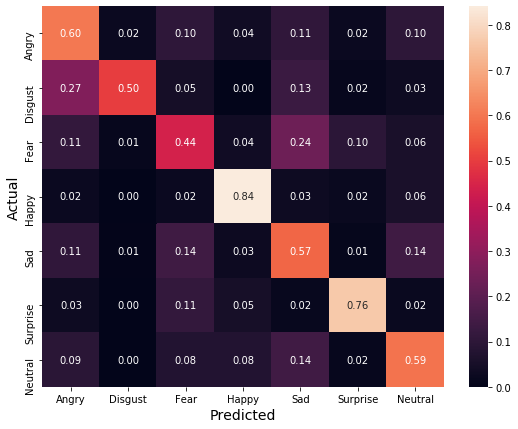

In [17]:
#Plotting Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Plotting Confusion Matrix for Validation set since the test dataset file does not have target labels
val_pred = model.predict(X_val)

#Val_Predictions has 7 outputs for each image. Hence, using argmax to gte the index of larget value
Val_Predictions = [np.argmax(val) for val in val_pred]

Y_val = [np.argmax(val) for val in Y_val]

#Get emotion labels for Xticklabel, yticklabels
emotions = image_dict.values()

cm = confusion_matrix(Y_val, Val_Predictions)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cmn, annot=True, fmt='.2f',xticklabels=emotions, yticklabels=emotions)
plt.ylabel('Actual',fontsize =14)
plt.xlabel('Predicted', fontsize=14)
plt.show()

In [0]:
#Confusion Matrix Analysis:
#The model is very good for predicting happy and surprised emotions since the values are 0.84 and 0.76 respectively. 

#However, with low value of 0.44 for fear, it indicates that model predicts poorly for fear class, 
#and model is getting confused fear class for sadness, based on the intersection value of (fear,sadness) on the fear row.

#Model also confuses Disgust face for Angry face based on the intersection values. And predicts second badly for disgust(0.50) after fear class (0.44).

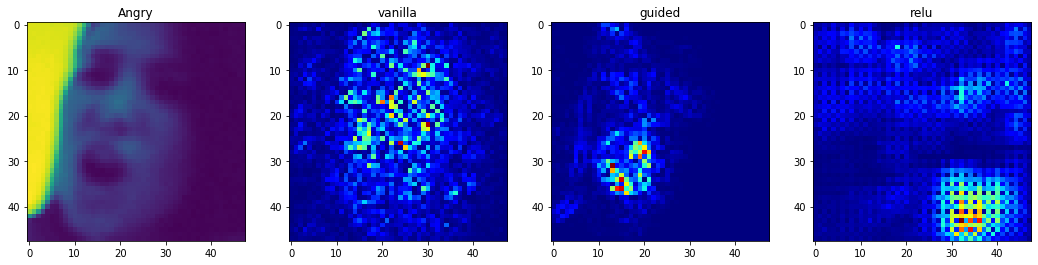

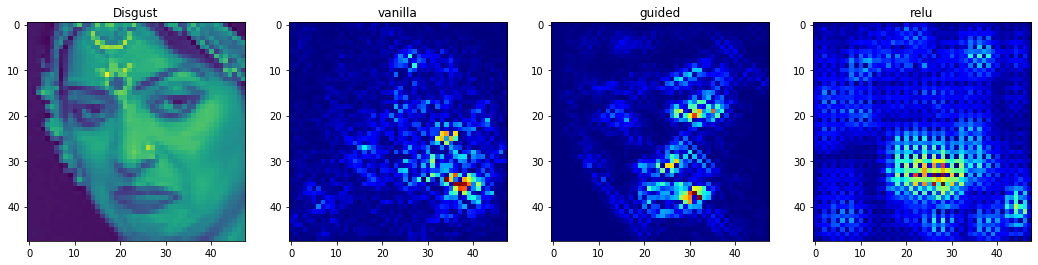

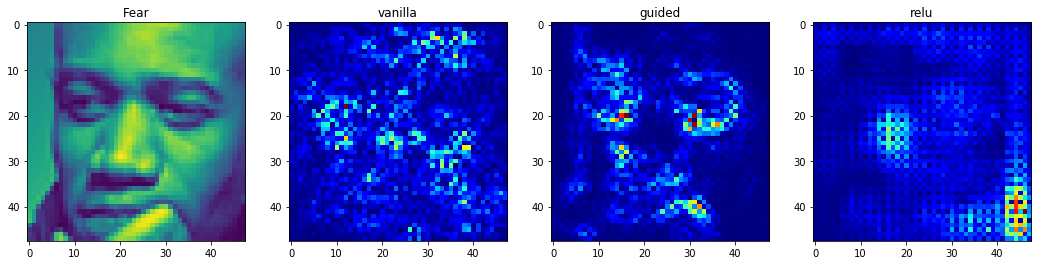

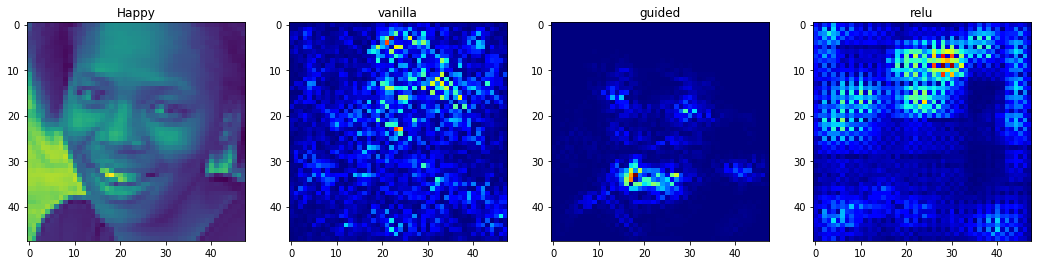

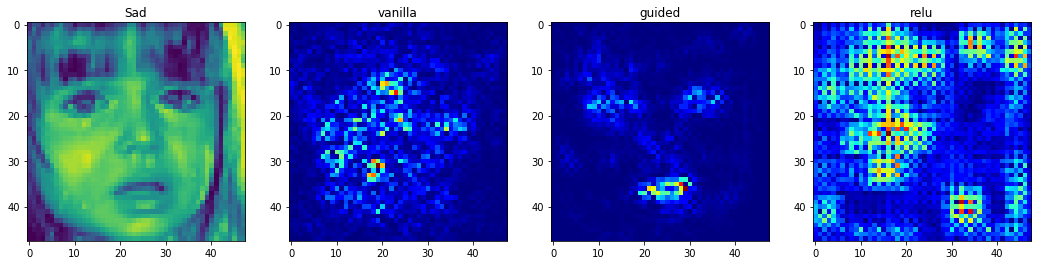

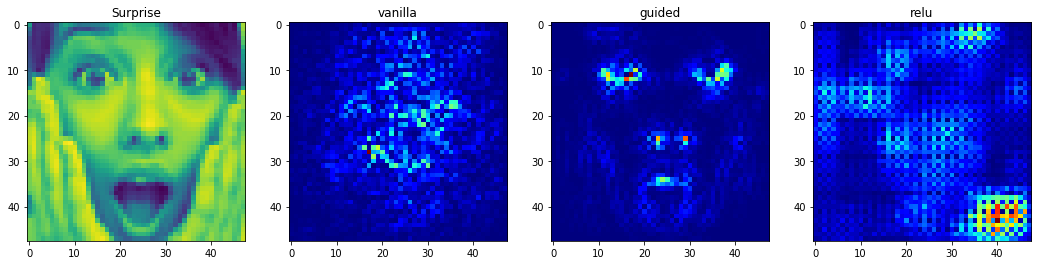

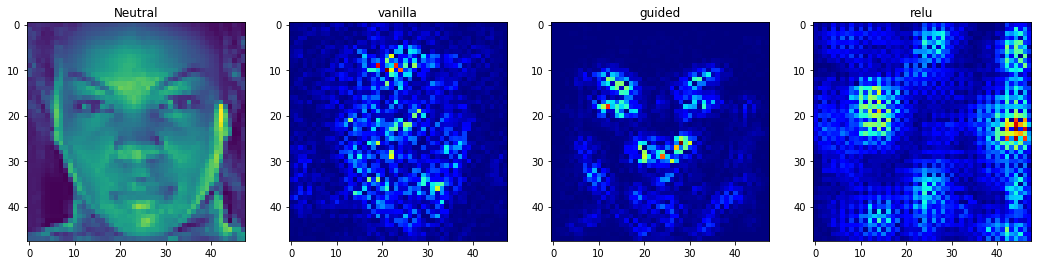

In [50]:
#Saliency Maps highlights the approximate location of an object in an image. 
#To plot the gradient of the predicted outcome from the model with respect to the input
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
from keras import activations

#Search for layer index by name for which we want to check the visualizations. 
#Here, we check the activations for the last dense layer which was names as 'visualized_layer'
layer_idx = utils.find_layer_idx(model, 'visualized_layer')

#Softmax activation swapped with linear activation since we are going to look backwards from outputs and fixed weights to inputs
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

#Displaying Saliency maps for all the target classes(7) using different backpropagation modifiers such as vanilla, guided, relu
for class_idx in np.arange(7):    
    indices = np.where(Y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

    #Displays the actual input image for every class
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_train[idx][..., 0])
    ax[0].set_title(image_dict[class_idx])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        #Calculate the gradients by using visualize_saliency(). It actually generates an attention heatmap
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=X_train[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)
        #Plotting the gradients with 'jet' colormap to visualize as a heatmap.    
        ax[i+1].imshow(grads, cmap='jet')

Surprise


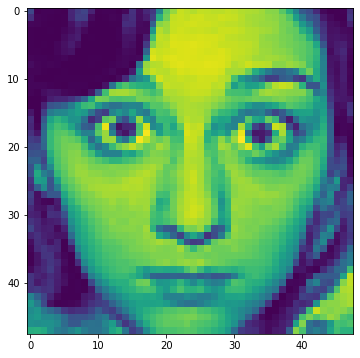

In [51]:
#Actual Image
class_idx = 0

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(X_val[0][..., 0])
print(image_dict[5])



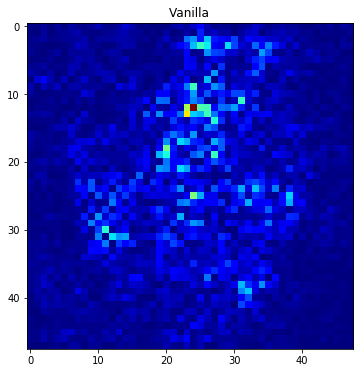

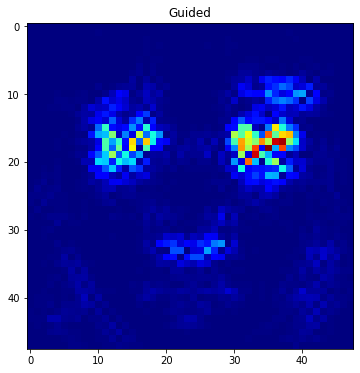

In [53]:
#Plot Saliency maps using vanilla and guided modifiers for the above Surprise emotion
idx=0

grads = visualize_saliency(model, layer_idx=layer_index, filter_indices=class_idx, seed_input=X_val[idx])
plt.title('Vanilla')
plt.imshow(grads, cmap='jet')


grads = visualize_saliency(model, layer_idx=layer_index, filter_indices=class_idx,
                               seed_input=X_val[idx], backprop_modifier='guided')
plt.figure()
plt.title('Guided')
plt.imshow(grads, cmap='jet')